# Clickbait Detection with Transformer Models

In this project, we will build and evaluate transformer-based models for detecting clickbait headlines. Clickbait refers to content with misleading or sensationalized headlines designed primarily to attract attention and encourage visitors to click on a link, often at the expense of accuracy or quality. Detecting clickbait automatically is an important NLP task with applications in content moderation and media literacy.


In [ ]:
# note that in handin.py this step would need to be removed
!pip install transformers datasets wandb

In [ ]:
# This code block has just standard setup code for running in Python

# Import PyTorch
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import random
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset

# For experiment tracking
import wandb

# Fix the random seed for reproducability
torch.random.manual_seed(8942764)
torch.cuda.manual_seed(8942764)
np.random.seed(8942764)

In [ ]:
# Please set your device by uncommenting the right version below

# On colab or on a machine with access to an Nvidia GPU  use the following setting
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# if you have an Apple Silicon machine with a GPU, use the following setting
# this should about 3-4 times faster that running it on a plain CPU
# device = 'mps' if torch.backends.mps.is_available() else 'cpu'

# If you will use a cpu, this is the setting
# device='cpu'

print(f"Using device: {device}")


Using device: cuda


## Utility Functions
These functions help with model setup, data processing, training, and evaluation.

In [ ]:
# Function to load the dataset
def load_data():
    """
    Load the clickbait dataset from Hugging Face

    Returns:
        dataset: A dataset dictionary containing train, validation, and test splits
    """
    # Use the load_dataset function to load the clickbait dataset
    # The dataset ID is "christinacdl/clickbait_notclickbait_dataset"
    dataset = load_dataset("christinacdl/clickbait_notclickbait_dataset")
    return dataset

In [ ]:
# Function to initialize and return instance of Autotokenizer with the given model name
def get_tokenizer(model_name):
    """
    Get the appropriate tokenizer for the given model name

    Args:
        model_name: Name of the pre-trained model (e.g., 'bert-base-uncased')

    Returns:
        tokenizer: The tokenizer for the specified model
    """
    # Load and return the pre-trained Autotokenizer for the specified model name
    return AutoTokenizer.from_pretrained(model_name)

In [ ]:
# Tokenization function for data processing
def tokenize(batch, tokenizer):
    """
    Transform text data to tokenized format for model input

    Args:
        batch: Batch of examples from the dataset
        tokenizer: Tokenizer to use for encoding

    Returns:
        Dict with tokenized inputs and labels
    """
    sentences = [x['text'] for x in batch]
    labels = torch.LongTensor([x['label'] for x in batch])
    new_batch = dict(tokenizer(sentences, padding=True, truncation=True, return_tensors="pt"))
    new_batch['label'] = labels
    return new_batch

In [ ]:
# Function to initialize wandb for experiment tracking
def init_wandb(config, project_name):
    """Initialize wandb with given config"""
    wandb.init(
        project=project_name,
        config=config
    )
    return wandb.config

In [ ]:
# Training function
def train(model,
          train_dataset,
          val_dataset,
          num_epochs,
          batch_size,
          optimizer_cls,
          lr,
          weight_decay,
          device,
          tokenizer,
          use_wandb=False):
    """
    Train the model and track with wandb if specified

    Args:
        model: Model to train
        train_dataset: Training dataset
        val_dataset: Validation dataset
        num_epochs: Number of epochs to train for
        batch_size: Batch size for training
        optimizer_cls: Name of optimizer to use ('SGD', 'Adam', 'AdamW')
        lr: Learning rate
        weight_decay: Weight decay for regularization
        device: Device to train on
        tokenizer: Tokenizer for processing inputs
        use_wandb: Whether to log metrics to wandb

    Returns:
        Tuple of (trained model, training history)
    """
    # Set the model to training mode and move it to the specified device
    model.train()
    model.to(device)


    dataloader = DataLoader(train_dataset, batch_size, shuffle=True,
                          collate_fn=lambda batch: tokenize(batch, tokenizer))

    # Initialize the optimizers based on the optimizer_cls parameter, with the specified learning rates and weight decays.
    if optimizer_cls == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_cls == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_cls == 'AdamW':
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_cls}")

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    lossfn = nn.CrossEntropyLoss()  # Using CrossEntropyLoss which expects logits

    global_step = 0

    for e in range(num_epochs):
        epoch_loss_history = []
        epoch_acc_history = []

        # Training loop
        model.train()
        for i, batch in enumerate(dataloader):
            batch = {k:v.to(device) for k,v in batch.items() if isinstance(v, torch.Tensor)}
            y = batch.pop('label')

            # Implement forward pass and loss computation
            # 1. Pass the batch through the model to get logits
            logits = model(**batch)
            # 2. Calculate the loss using lossfn
            loss = lossfn(logits, y)
            # 3. Calculate the accuracy (percentage of correct predictions)
            preds = torch.argmax(logits, dim=1)
            acc = (preds == y).float().mean()
            # 4. Append each epoch's loss and accuracy to epoch_loss_history and epoch_acc_history
            epoch_loss_history.append(loss.item())
            epoch_acc_history.append(acc.item())

            global_step += 1

            # Print every 100 steps
            if global_step % 100 == 0:
                print(f'Epoch: {e+1}, Step: {global_step}, Train Loss: {epoch_loss_history[-1]:.3e}, Train Accuracy: {epoch_acc_history[-1]:.3f}')

                # Log batch metrics to WandB
                if use_wandb:
                    wandb.log({
                        "global_step": global_step,  # Correct step tracking
                        "train_loss_step": epoch_loss_history[-1],  # Current batch loss
                        "train_accuracy_step": epoch_acc_history[-1],  # Current batch accuracy
                        "epoch": e + 1,
                    })

            # Implement backward pass and optimization step
            # 1. Zero the gradients
            optimizer.zero_grad()
            # 2. Backpropagate the loss
            loss.backward()
            # 3. Update the model parameters using the optimizer
            optimizer.step()

        # Evaluation on validation set
        # Set the model to Evaluation mode
        model.eval()
        val_loss, val_acc, _, _, _ = evaluate(model, val_dataset, batch_size, device, tokenizer)

        train_loss_history.append(np.mean(epoch_loss_history))
        train_acc_history.append(np.mean(epoch_acc_history))
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        print(f'epoch: {e + 1}\t train_loss: {train_loss_history[-1]:.3e}\t train_accuracy:{train_acc_history[-1]:.3f}\t val_loss: {val_loss_history[-1]:.3e}\t val_accuracy:{val_acc_history[-1]:.3f}')

        # Log metrics to wandb if enabled
        if use_wandb:
            wandb.log({
                "epoch": e + 1,
                "train_loss": train_loss_history[-1],
                "train_accuracy": train_acc_history[-1],
                "val_loss": val_loss_history[-1],
                "val_accuracy": val_acc_history[-1]
            })

    return model, (train_loss_history, train_acc_history, val_loss_history, val_acc_history)

In [ ]:
# Evaluation function
@torch.no_grad()
def evaluate(model, dataset, batch_size, device, tokenizer):
    """
    Evaluate model on dataset

    Args:
        model: Model to evaluate
        dataset: Dataset to evaluate on
        batch_size: Batch size for evaluation
        device: Device to run evaluation on
        tokenizer: Tokenizer for processing inputs

    Returns:
        Tuple of (loss, accuracy, predictions, labels, logits)
    """
    # Set the model to evaluation mode and move it to the specified device
    model.eval()
    model.to(device)


    dataloader = DataLoader(dataset, batch_size, shuffle=False,
                           collate_fn=lambda batch: tokenize(batch, tokenizer))
    lossfn = nn.CrossEntropyLoss()  # Using CrossEntropyLoss which expects logits

    loss_history = []
    acc_history = []
    all_preds = []
    all_labels = []
    all_logits = []

    for i, batch in enumerate(dataloader):
        batch = {k:v.to(device) for k,v in batch.items() if isinstance(v, torch.Tensor)}
        y = batch.pop('label')

        # Implement the evaluation loop
        # Loop through batches in the dataloader
        # 1. Get model predictions by passing in the batch (logits)
        logits = model(**batch)
        # 2. Calculate loss
        loss = lossfn(logits, y)
        # 3. Get the predictions from the logits in the variable pred
        pred = torch.argmax(logits, dim=1)


        acc = (pred == y).float().mean()

        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        all_logits.extend(logits.cpu().numpy())

        loss_history.append(loss.item())
        acc_history.append(acc.item())

    # Calculate and return the evaluation metrics
    # Return the mean loss, mean accuracy, all predictions, all labels, and all logits
    mean_loss = np.mean(loss_history)
    mean_acc = np.mean(acc_history)

    return mean_loss, mean_acc, all_preds, all_labels, all_logits

In [ ]:
# Function to load a test set and generate predictions
def predict_on_test_set(model, tokenizer, test_file_path, output_file_path, device):
    """
    Generate predictions on a test set and save to file

    Args:
        model: Trained model
        tokenizer: Tokenizer for the model
        test_file_path: Path to the test data file
        output_file_path: Path to save predictions
        device: Device to run inference on
    """
    # Load test data
    with open(test_file_path, 'r') as f:
        test_data = json.load(f)

    print(f"Loaded {len(test_data)} examples from {test_file_path}")

    # Make predictions
    # Set the model to evaluation mode
    model.eval()
    model.to(device)

    # Initialize an empty list to store predictions
    predictions = []

    for item in test_data:
        # Tokenize the text and move to the correct device as variable inputs
        inputs = tokenizer(item['text'], return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Get predictions
        # Disable gradient propagation
        with torch.no_grad():
            # Pass the inputs to the model to get logits
            logits = model(**inputs)
            # Get the prediction from the logits
            pred = torch.argmax(logits, dim=1).item()

        # Store prediction as a string (0 or 1)
        predictions.append(str(pred))

    # Write predictions to file - one prediction per line
    with open(output_file_path, 'w') as f:
        f.write('\n'.join(predictions))

    print(f"Predictions saved to {output_file_path}")

## Model Architecture
This section defines the model architecture for transformer-based text classification.


In [ ]:
# Base Transformer Model class for text classification
class TransformerForTextClassification(nn.Module):
    def __init__(self, model_name, num_classes, freeze_base=False, hidden_size=128, num_layers=1):
        """
        Transformer model with a classification head

        Args:
            model_name: Name of the base transformer model (e.g., 'bert-base-uncased')
            num_classes: Number of output classes
            freeze_base: Whether to freeze the base model parameters
            hidden_size: Size of the hidden layers in the classifier
            num_layers: Number of hidden layers in the classifier
        """
        super().__init__()

        self.base_model = AutoModel.from_pretrained(model_name)

        # Freeze base model if specified
        self.base_model.requires_grad_(not freeze_base)

        if not freeze_base:
            self.unfreeze_top_k_layers(5)

        # Get the hidden size from the base model config
        base_hidden_size = self.base_model.config.hidden_size

        # Build classifier with variable number of hidden layers
        if num_layers == 1:
            self.classifier = nn.Sequential(
                # Build classifier with variable number of hidden layers
                # For num_layers=1, create a classifier with:
                #   - Linear layer from base_hidden_size to hidden_size
                #   - ReLU activation
                #   - Linear layer from hidden_size to num_classes
                nn.Linear(base_hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, num_classes)
            )
        elif num_layers == 2:
            self.classifier = nn.Sequential(
                # For num_layers=2, add an additional hidden layer
                nn.Linear(base_hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, num_classes)
            )
        elif num_layers == 3:
            self.classifier = nn.Sequential(
                # For num_layers=3, add two additional hidden layers
                nn.Linear(base_hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, num_classes)
            )
        else:
            raise ValueError(f"Unsupported number of layers: {num_layers}")

    def unfreeze_top_k_layers(self, k=5):
        """
        Unfreezes the top k layers of a Transformer model (BERT or ModernBERT).

        Parameters:
            model: The Transformer model (e.g., BERT or ModernBERT).
            k: Number of top layers to unfreeze (default is 5).
        """
        # First, freeze all layers in the base model
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Detect whether the model uses standard BERT or ModernBERT
        if hasattr(self.base_model, "encoder"):  # Standard BERT
            layers = self.base_model.encoder.layer
        elif hasattr(self.base_model, "layers"):  # ModernBERT
            layers = self.base_model.layers
        else:
            raise ValueError("Unrecognized model architecture: Cannot find encoder layers.")

        # Get the total number of layers
        total_layers = len(layers)

        # Unfreeze the last k layers
        for i in range(total_layers - k, total_layers):
            for param in layers[i].parameters():
                # Unfreeze this layer
                param.requires_grad = True

        print(f"Unfroze the last {k} layers out of {total_layers} total layers.")

    def forward(self, **base_model_kwargs):
        """Forward pass through the model"""
        outputs = self.base_model(**base_model_kwargs)
        # Use the pooled output for classification
        pooled_output = outputs.last_hidden_state[:, 0, :] # Extract the [CLS] token embedding from the last hidden state
        # Return logits (not probabilities)
        logits = self.classifier(pooled_output) # Pass the pooled output through the classifier to get logits
        return logits

In [ ]:
# Function to create model with specified architecture
def get_model(model_name, num_classes, freeze_base=False, hidden_size=128, num_layers=1):
    """Create model with specified architecture"""
    return TransformerForTextClassification(
        model_name=model_name,
        num_classes=num_classes,
        freeze_base=freeze_base,
        hidden_size=hidden_size,
        num_layers=num_layers
    )

### Dataset
We'll be using a dataset of headlines labeled as either clickbait (1) or not clickbait (0). The dataset comes from Hugging Face and includes training, validation, and test splits. You'll have an opportunity to explore the data distribution and characteristics before building your models.


In [ ]:
# Load dataset
dataset = load_data()
print(dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/437 [00:00<?, ?B/s]

train.json: 0.00B [00:00, ?B/s]

val.json: 0.00B [00:00, ?B/s]

test.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/43802 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2191 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8760 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 43802
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 2191
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 8760
    })
})


In [ ]:
# Look at some examples
print("\nExamples from training set:")
for i in range(3):
    print(f"Example {i}: {dataset['train'][i]}")

print("\nExamples from validation set:")
for i in range(3):
    print(f"Example {i}: {dataset['validation'][i]}")


Examples from training set:
Example 0: {'label': 0, 'text': 'Alphabet Scraps Plan to Blanket Globe With Internet Balloons'}
Example 1: {'label': 0, 'text': 'US Boy Scouts and hikers airlifted from wildfire in Utah'}
Example 2: {'label': 1, 'text': "Here's What Happened When I Road Tripped Around Southern California For A Week"}

Examples from validation set:
Example 0: {'label': 1, 'text': '27 Happy Gifts For People Who Love Jamaica'}
Example 1: {'label': 1, 'text': 'How Adulthood Happens '}
Example 2: {'label': 0, 'text': 'President Donald Trump Has Historically Low Approval Ratings As He Nears 100-Day Mark'}


In [ ]:
# Look at class distribution
train_labels = [example['label'] for example in dataset['train']]
val_labels = [example['label'] for example in dataset['validation']]
test_labels = [example['label'] for example in dataset['test']]

print("\nClass distribution:")
print(f"Training set: Clickbait: {train_labels.count(1)}, Not clickbait: {train_labels.count(0)}")
print(f"Validation set: Clickbait: {val_labels.count(1)}, Not clickbait: {val_labels.count(0)}")
print(f"Test set: Clickbait: {test_labels.count(1)}, Not clickbait: {test_labels.count(0)}")



Class distribution:
Training set: Clickbait: 16257, Not clickbait: 27545
Validation set: Clickbait: 813, Not clickbait: 1378
Test set: Clickbait: 3252, Not clickbait: 5508


## Explore tokenization

In [ ]:
# Explore tokenization
bert_tokenizer = get_tokenizer("bert-base-uncased")
modernbert_tokenizer = get_tokenizer("answerdotai/ModernBERT-base")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

In [ ]:
print("\nTokenization examples:")
example_text = dataset['train'][8]['text']
print(f"Original text: '{example_text}'")
print(f"BERT tokenization: {bert_tokenizer.tokenize(example_text)}")
print(f"ModernBERT tokenization: {modernbert_tokenizer.tokenize(example_text)}")


Tokenization examples:
Original text: '15 Things You Never Noticed About Owning A Cat'
BERT tokenization: ['15', 'things', 'you', 'never', 'noticed', 'about', 'owning', 'a', 'cat']
ModernBERT tokenization: ['15', 'ĠThings', 'ĠYou', 'ĠNever', 'ĠNot', 'iced', 'ĠAbout', 'ĠOw', 'ning', 'ĠA', 'ĠCat']


## Task 1: Model Selection

In this task, you will compare the performance of two different transformer architectures for the clickbait detection task:

1. **BERT (bert-base-uncased)**: A widely-used transformer model developed by Google that has been pre-trained on a large corpus of English text.

2. **ModernBERT (answerdotai/ModernBERT-base)**: A more recent transformer variant that has been trained on newer text data and may have better performance on contemporary language patterns.

You'll train and evaluate both models with the same baseline configuration to determine which architecture provides a stronger foundation for our clickbait detection system.

This comparison will help us understand:
- Which model better captures the linguistic patterns characteristic of clickbait
- Whether the newer ModernBERT has advantages over the classic BERT architecture for this specific application

After completing this task, you'll select the better-performing model to use as the foundation for further refinement in Task 2.

In [ ]:
def run_model_selection():
    """Run model selection task comparing BERT and RoBERTa"""

    # Define models to compare
    model_configs = [
        {
            "name": "bert-base-uncased",
            "display_name": "BERT",
            "freeze_base": True
        },
        {
            "name": "answerdotai/ModernBERT-base",
            "display_name": "ModernBERT",
            "freeze_base": True
        }
    ]

    # Training parameters
    train_params = {
        "num_epochs": 3,
        "batch_size": 32,
        "optimizer_cls": "Adam",
        "lr": 1e-3,
        "weight_decay": 1e-4,
        "hidden_size": 128,
        "num_layers": 1
    }

    results = []

    for config in model_configs:
        model_name = config["name"]
        display_name = config["display_name"]
        print(f"\n{'='*50}")
        print(f"Training and evaluating {display_name} model")
        print(f"{'='*50}")

        tokenizer = get_tokenizer(model_name) # Initialize the tokenizer for the selected model using the get_tokenizer function defined before

        # Initialize wandb
        wandb_config = {**config, **train_params}
        # init_wandb(wandb_config, "clickbait-detection-task1-1")
        wandb.init(
            project="clickbait-detection-task1-5",
            config=wandb_config,
            name=config["display_name"]
        )

        # Create model
        model = get_model(
            model_name=model_name,
            num_classes=2,
            freeze_base=config["freeze_base"],
            hidden_size=train_params["hidden_size"],
            num_layers=train_params["num_layers"]
        )

        # Print the number of trainable parameters in the model
        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Model trainable parameters: {num_params}")

        # Train model
        model, logs = train(
            model=model,
            train_dataset=dataset['train'],
            val_dataset=dataset['validation'],
            num_epochs=train_params["num_epochs"],
            batch_size=train_params["batch_size"],
            optimizer_cls=train_params["optimizer_cls"],
            lr=train_params["lr"],
            weight_decay=train_params["weight_decay"],
            device=device,
            tokenizer=tokenizer,
            use_wandb=True
        )

        # Evaluate on validation set
        val_loss, val_acc, _, _, _ = evaluate(
            model=model,
            dataset=dataset['validation'],
            batch_size=train_params["batch_size"],
            device=device,
            tokenizer=tokenizer
        )

        # Record results
        results.append({
            "model_name": model_name,
            "display_name": display_name,
            "val_accuracy": val_acc,
            "val_loss": val_loss,
            "logs": logs,
            "model": model,
            "tokenizer": tokenizer
        })

        wandb.finish()

    # Compare results
    print("\nModel Selection Results:")
    print(f"{'Model':<10} {'Validation Accuracy':<20} {'Validation Loss':<15}")
    print("-" * 45)

    for result in results:
        print(f"{result['display_name']:<10} {result['val_accuracy']:.4f}{' '*15} {result['val_loss']:.4f}")

    return results

In [ ]:
# Run model selection
task1_results = run_model_selection()


Training and evaluating BERT model


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: juzodinma (juzodinma-carnegie-mellon-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Model trainable parameters: 98690
Epoch: 1, Step: 100, Train Loss: 3.486e-01, Train Accuracy: 0.844
Epoch: 1, Step: 200, Train Loss: 1.737e-01, Train Accuracy: 0.906
Epoch: 1, Step: 300, Train Loss: 3.378e-01, Train Accuracy: 0.906
Epoch: 1, Step: 400, Train Loss: 1.531e-01, Train Accuracy: 0.969
Epoch: 1, Step: 500, Train Loss: 2.100e-01, Train Accuracy: 0.969
Epoch: 1, Step: 600, Train Loss: 3.693e-01, Train Accuracy: 0.812
Epoch: 1, Step: 700, Train Loss: 2.304e-01, Train Accuracy: 0.906
Epoch: 1, Step: 800, Train Loss: 2.138e-01, Train Accuracy: 0.938
Epoch: 1, Step: 900, Train Loss: 3.784e-01, Train Accuracy: 0.875
Epoch: 1, Step: 1000, Train Loss: 2.366e-01, Train Accuracy: 0.875
Epoch: 1, Step: 1100, Train Loss: 2.149e-01, Train Accuracy: 0.875
Epoch: 1, Step: 1200, Train Loss: 3.038e-01, Train Accuracy: 0.906
Epoch: 1, Step: 1300, Train Loss: 3.032e-01, Train Accuracy: 0.875
epoch: 1	 train_loss: 2.916e-01	 train_accuracy:0.883	 val_loss: 2.825e-01	 val_accuracy:0.897
Epoch: 2,

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
train_accuracy,▁▇█
train_accuracy_step,▄▅▅▇▇▃▅▆▅▅▅▅▅▄▁▅▆▅▂▇▇▅▄▅▄▅▅█▆▆▅▅▆▇▇▅▄▅▃▃
train_loss,█▃▁
train_loss_step,▅▂▄▁▂▅▃▂▅▃▂▄▄▃▅▄▂▂█▂▁▂▅▃▆▃▂▁▂▃▄▅▁▂▁▄▅▂▄▅
val_accuracy,█▁▅
val_loss,█▄▁
epoch,3
global_step,4100
train_accuracy,0.89707



Training and evaluating ModernBERT model


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Model trainable parameters: 98690


/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:282: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


Epoch: 1, Step: 100, Train Loss: 6.223e-01, Train Accuracy: 0.750
Epoch: 1, Step: 200, Train Loss: 5.656e-01, Train Accuracy: 0.719
Epoch: 1, Step: 300, Train Loss: 1.991e-01, Train Accuracy: 0.969
Epoch: 1, Step: 400, Train Loss: 3.309e-01, Train Accuracy: 0.875
Epoch: 1, Step: 500, Train Loss: 2.912e-01, Train Accuracy: 0.844
Epoch: 1, Step: 600, Train Loss: 2.640e-01, Train Accuracy: 0.844
Epoch: 1, Step: 700, Train Loss: 2.975e-01, Train Accuracy: 0.906
Epoch: 1, Step: 800, Train Loss: 1.552e-01, Train Accuracy: 0.938
Epoch: 1, Step: 900, Train Loss: 4.831e-01, Train Accuracy: 0.781
Epoch: 1, Step: 1000, Train Loss: 5.035e-01, Train Accuracy: 0.750
Epoch: 1, Step: 1100, Train Loss: 1.736e-01, Train Accuracy: 0.938
Epoch: 1, Step: 1200, Train Loss: 1.135e-01, Train Accuracy: 0.969
Epoch: 1, Step: 1300, Train Loss: 1.420e-01, Train Accuracy: 0.938
epoch: 1	 train_loss: 2.982e-01	 train_accuracy:0.882	 val_loss: 2.726e-01	 val_accuracy:0.893
Epoch: 2, Step: 1400, Train Loss: 5.264e-01

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
train_accuracy,▁▇█
train_accuracy_step,▂▁▇▅▄▄▆▆▃▂▆▇▆▃▃▆▅▆█▄▆▃▃▇▆▆▆▆▆▆▅▅▆▃▅█▇▅▄▄
train_loss,█▂▁
train_loss_step,█▇▃▄▄▄▄▂▆▇▂▂▂▇▆▃▃▃▁▆▃▄▅▂▃▄▃▂▃▂▄▄▃▆▇▁▂▄▆▅
val_accuracy,▁▄█
val_loss,█▁▁
epoch,3
global_step,4100
train_accuracy,0.90129



Model Selection Results:
Model      Validation Accuracy  Validation Loss
---------------------------------------------
BERT       0.8935                0.2712
ModernBERT 0.9026                0.2522


In [ ]:
# Get the best model from Task 1 results
# 1. Find the model with the highest validation accuracy in task1_results
best_result = max(task1_results, key=lambda x: x['val_accuracy'])
# 2. Extract the model, model_name, and tokenizer from the best result

# 3. Print information about which model will be used for further tasks

best_model = best_result['model']
best_model_name = best_result['model_name']
best_tokenizer = best_result['tokenizer']

print(f"\nBest model from Task 1: {best_model_name}")
print(f"Using {best_model_name} for further tasks")


Best model from Task 1: answerdotai/ModernBERT-base
Using answerdotai/ModernBERT-base for further tasks


## Task 2: Hyperparameter Tuning

Now that we have selected the best model architecture, let's tune its hyperparameters to optimize performance.

In this task, you'll experiment with different hyperparameter configurations to find the best model. You should explore variations in:

- **Hidden layer sizes**: Try different sizes for the hidden layers in your classifier (e.g., 64, 128, 256, 512)
- **Number of hidden layers**: Experiment with adding more layers to your classifier (e.g., 1, 2, 3 layers)
- **Batch sizes**: Test different batch sizes (e.g., 16, 32, 64) - note that larger batch sizes may cause memory issues
- **Learning rates**: Try different learning rates (e.g., 1e-3, 5e-4, 1e-4)
- **Freezing base parameters**: Experiment with keeping the whole base model frozen vs unfreezing just the top 5 layers of the base model.
- **Optimizer**: You can try different optimizers like Adam, AdamW, or SGD

You should run at least 5 different hyperparameter configurations and track their performance using wandb. Below is a template for setting up your experiments.


In [ ]:
hp_configs = [
    # Configuration 1 (baseline)
    {
        "config_name": "Baseline",
        "hidden_size": 128,
        "num_layers": 1,
        "batch_size": 32,
        "optimizer": "Adam",
        "learning_rate": 1e-3,
        "weight_decay": 1e-4,
        "freeze_base": True,
        "num_epochs": 5
    },

    # Configuration 2: Medium hidden size, large batch, lower LR
    {
        "config_name": "AdamW LargeBatch",
        "hidden_size": 256,
        "num_layers": 2,
        "batch_size": 64,
        "optimizer": "AdamW",
        "freeze_base": False,
        "learning_rate": 2e-5,
        "weight_decay": 1e-4,
        "num_epochs": 5
    },

    # Configuration 3: Larger hidden size, more layers and low Learning rate
    {
        "config_name": "LargeHidden LowLR",
        "hidden_size": 512,
        "num_layers": 3,
        "batch_size": 32,
        "optimizer": "AdamW",
        "freeze_base": False,
        "learning_rate": 3e-5,
        "weight_decay": 1e-4,
        "num_epochs": 5
    },

    # Configuration 4: Larger hidden size with slightly lower LR and unfrozen optimizer
    {
        "config_name": "Freeze LargeHidden",
        "hidden_size": 256,
        "num_layers": 1,
        "batch_size": 32,
        "optimizer": "AdamW",
        "freeze_base": True,
        "learning_rate": 5e-4,
        "weight_decay": 1e-4,
        "num_epochs": 5
    },

    # Configuration 5: larger hidden size and Unfreeze base
    {
        "config_name": "LargeHidden LowLayer",
        "hidden_size": 256,
        "num_layers": 1,
        "batch_size": 32,
        "optimizer": "AdamW",
        "freeze_base": False,
        "learning_rate": 2e-5,
        "weight_decay": 1e-4,
        "num_epochs": 5
    },

    # Configuration 6: Larger hidden size, more layers and moderate batch
    {
        "config_name": "LargeHidden LowBatch",
        "hidden_size": 512,
        "num_layers": 3,
        "batch_size": 16,
        "optimizer": "AdamW",
        "freeze_base": False,
        "learning_rate": 2e-5,
        "weight_decay": 1e-4,
        "num_epochs": 5
    },

    # Configuration 7: Medium hidden size, large batch, lower LR
    {
        "config_name": "LargeHidden MoreLayers",
        "hidden_size": 256,
        "num_layers": 3,
        "batch_size": 32,
        "optimizer": "AdamW",
        "freeze_base": False,
        "learning_rate": 5e-5,
        "weight_decay": 1e-4,
        "num_epochs": 5
    },

]

In [ ]:
def run_hyperparameter_tuning(model_name, base_tokenizer):
    """
    Run hyperparameter tuning experiments

    Args:
        model_name: Name of the model to use
        base_tokenizer: Tokenizer for the model

    Returns:
        List of experiment results
    """
    print(f"\n{'='*50}")
    print(f"Running Hyperparameter Tuning for {model_name}")
    print(f"{'='*50}")

    results = []
    best_val_acc = 0
    best_config_idx = 0
    best_model = None

    # For each configuration in your hp_configs list
    for i, config in enumerate(hp_configs):
        print(f"\nRunning experiment {i+1}/{len(hp_configs)}: {config['config_name']}")

        # Initialize wandb for this experiment
        wandb_config = {**config, "model_name": model_name}
        # init_wandb(wandb_config, "clickbait-detection-task2-1")
        wandb.init(
            project="clickbait-detection-task2-5",
            config=wandb_config,
            name=config["config_name"]
        )

        # Create model with this configuration
        model = get_model(
            model_name=model_name,
            num_classes=2,
            freeze_base=config["freeze_base"],
            hidden_size=config["hidden_size"],
            num_layers=config["num_layers"]
        )

        # Train model
        model, logs = train(
            model=model,
            train_dataset=dataset['train'],
            val_dataset=dataset['validation'],
            num_epochs=config["num_epochs"],
            batch_size=config["batch_size"],
            optimizer_cls=config["optimizer"],
            lr=config["learning_rate"],
            weight_decay=config["weight_decay"],
            device=device,
            tokenizer=base_tokenizer,
            use_wandb=True
        )

        # Evaluate on validation set
        val_loss, val_acc, _, _, _ = evaluate(
            model=model,
            dataset=dataset['validation'],
            batch_size=config["batch_size"],
            device=device,
            tokenizer=base_tokenizer
        )

        # Log final validation metrics
        wandb.log({
            "final_val_loss": val_loss,
            "final_val_accuracy": val_acc
        })

        # Finish wandb run
        wandb.finish()

        # Record results
        results.append({
            "config_name": config["config_name"],
            "hidden_size": config["hidden_size"],
            "num_layers": config["num_layers"],
            "batch_size": config["batch_size"],
            "learning_rate": config["learning_rate"],
            "weight_decay": config["weight_decay"],
            "optimizer": config["optimizer"],
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "model": model
        })

        # Keep track of best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_config_idx = i
            best_model = model

    # Display results in a table
    print("\nHyperparameter Tuning Results:")
    print("-" * 120)
    print(f"{'Config':<10} {'Hidden Size':<12} {'Layers':<8} {'Batch Size':<12} {'Learning Rate':<14} {'Weight Decay':<14} {'Optimizer':<10} {'Val Accuracy':<15}")
    print("-" * 120)

    for result in results:
        print(f"{result['config_name']:<10} {result['hidden_size']:<12} {result['num_layers']:<8} {result['batch_size']:<12} {result['learning_rate']:<14} {result['weight_decay']:<14} {result['optimizer']:<10} {result['val_accuracy']:.4f}")

    print("-" * 120)
    print(f"Best configuration: {results[best_config_idx]['config_name']} with validation accuracy: {best_val_acc:.4f}")

    return results, best_model, best_config_idx

In [ ]:
# Run Task 2: Hyperparameter Tuning
# Run all hyperparameter experiments
tuning_results, best_tuned_model, best_config_idx = run_hyperparameter_tuning(best_model_name, best_tokenizer)



Running Hyperparameter Tuning for answerdotai/ModernBERT-base

Running experiment 1/7: Baseline


Epoch: 1, Step: 100, Train Loss: 4.093e-01, Train Accuracy: 0.844
Epoch: 1, Step: 200, Train Loss: 2.605e-01, Train Accuracy: 0.875
Epoch: 1, Step: 300, Train Loss: 3.315e-01, Train Accuracy: 0.875
Epoch: 1, Step: 400, Train Loss: 2.737e-01, Train Accuracy: 0.938
Epoch: 1, Step: 500, Train Loss: 1.766e-01, Train Accuracy: 0.969
Epoch: 1, Step: 600, Train Loss: 2.082e-01, Train Accuracy: 0.906
Epoch: 1, Step: 700, Train Loss: 1.709e-01, Train Accuracy: 0.969
Epoch: 1, Step: 800, Train Loss: 2.055e-01, Train Accuracy: 0.938
Epoch: 1, Step: 900, Train Loss: 3.040e-01, Train Accuracy: 0.844
Epoch: 1, Step: 1000, Train Loss: 3.364e-01, Train Accuracy: 0.906
Epoch: 1, Step: 1100, Train Loss: 1.610e-01, Train Accuracy: 0.969
Epoch: 1, Step: 1200, Train Loss: 3.283e-01, Train Accuracy: 0.875
Epoch: 1, Step: 1300, Train Loss: 2.780e-01, Train Accuracy: 0.906
epoch: 1	 train_loss: 2.996e-01	 train_accuracy:0.882	 val_loss: 2.836e-01	 val_accuracy:0.886
Epoch: 2, Step: 1400, Train Loss: 3.008e-01

epoch,▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆██████████
final_val_accuracy,▁
final_val_loss,▁
global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
train_accuracy,▁▅▇▇█
train_accuracy_step,▄▆▇▅▇▅▅▇▄▅▅▅▂▁▆▅▂▅▆▅▅▅▅▅█▆▆▅▅▆▅▆▅▄▅▅▅▄▇▅
train_loss,█▄▂▂▁
train_loss_step,▆▄▅▄▂▂▃▄▅▂▄▂▄▅█▄▃▃▅▂▃▄▄▂▅▄▁▄█▂▃▅▃▂▆▅▅▂▃▃
val_accuracy,▁▇██▆
val_loss,█▁▂▁▃
epoch,5



Running experiment 2/7: AdamW LargeBatch


Unfroze the last 5 layers out of 22 total layers.
Epoch: 1, Step: 100, Train Loss: 2.977e-01, Train Accuracy: 0.906
Epoch: 1, Step: 200, Train Loss: 2.944e-01, Train Accuracy: 0.891
Epoch: 1, Step: 300, Train Loss: 3.305e-01, Train Accuracy: 0.891
Epoch: 1, Step: 400, Train Loss: 1.460e-01, Train Accuracy: 0.984
Epoch: 1, Step: 500, Train Loss: 2.336e-01, Train Accuracy: 0.938
Epoch: 1, Step: 600, Train Loss: 2.661e-01, Train Accuracy: 0.875
epoch: 1	 train_loss: 2.873e-01	 train_accuracy:0.888	 val_loss: 2.535e-01	 val_accuracy:0.899
Epoch: 2, Step: 700, Train Loss: 1.851e-01, Train Accuracy: 0.938
Epoch: 2, Step: 800, Train Loss: 2.068e-01, Train Accuracy: 0.938
Epoch: 2, Step: 900, Train Loss: 2.214e-01, Train Accuracy: 0.906
Epoch: 2, Step: 1000, Train Loss: 1.500e-01, Train Accuracy: 0.953
Epoch: 2, Step: 1100, Train Loss: 1.820e-01, Train Accuracy: 0.938
Epoch: 2, Step: 1200, Train Loss: 2.362e-01, Train Accuracy: 0.891
Epoch: 2, Step: 1300, Train Loss: 2.649e-01, Train Accuracy:

epoch,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
final_val_accuracy,▁
final_val_loss,▁
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
train_accuracy,▁▃▄▆█
train_accuracy_step,▄▃▃▇▅▂▅▅▄▆▅▃▁▆▇▆▆▅▆▄▇▆▇▅▅▆▇▇█▇▇▆█▇
train_loss,█▆▅▃▁
train_loss_step,▇▇█▄▆▇▅▅▆▄▅▆▇▅▃▃▅▅▄▅▂▂▄▅▆▃▃▁▁▂▂▃▁▂
val_accuracy,▁█▄▅▂
val_loss,▃▁▁▄█
epoch,5



Running experiment 3/7: LargeHidden LowLR


Unfroze the last 5 layers out of 22 total layers.
Epoch: 1, Step: 100, Train Loss: 3.698e-01, Train Accuracy: 0.781
Epoch: 1, Step: 200, Train Loss: 2.081e-01, Train Accuracy: 0.938
Epoch: 1, Step: 300, Train Loss: 2.694e-01, Train Accuracy: 0.906
Epoch: 1, Step: 400, Train Loss: 3.445e-01, Train Accuracy: 0.844
Epoch: 1, Step: 500, Train Loss: 2.651e-01, Train Accuracy: 0.875
Epoch: 1, Step: 600, Train Loss: 8.030e-02, Train Accuracy: 1.000
Epoch: 1, Step: 700, Train Loss: 9.285e-02, Train Accuracy: 0.969
Epoch: 1, Step: 800, Train Loss: 2.551e-01, Train Accuracy: 0.938
Epoch: 1, Step: 900, Train Loss: 2.904e-01, Train Accuracy: 0.875
Epoch: 1, Step: 1000, Train Loss: 2.446e-01, Train Accuracy: 0.906
Epoch: 1, Step: 1100, Train Loss: 2.452e-01, Train Accuracy: 0.875
Epoch: 1, Step: 1200, Train Loss: 2.453e-01, Train Accuracy: 0.844
Epoch: 1, Step: 1300, Train Loss: 8.681e-02, Train Accuracy: 0.969
epoch: 1	 train_loss: 2.567e-01	 train_accuracy:0.901	 val_loss: 2.240e-01	 val_accuracy

epoch,▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆███████
final_val_accuracy,▁
final_val_loss,▁
global_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,▁▃▅▇█
train_accuracy_step,▁▅▃▄█▅▃▇▅▆█▇▇█▆█▆▇▆▆▆███▇▆████▇█████████
train_loss,█▆▄▂▁
train_loss_step,▅▆█▆▃▇▆▆▆▃▃▇▃▂▄▃▅▃▃▃▁▃▃▃▃▄▁▁▃▁▁▂▁▂▃▁▁▁▁▁
val_accuracy,▇▄█▄▁
val_loss,▁▁▂▅█
epoch,5



Running experiment 4/7: Freeze LargeHidden


Epoch: 1, Step: 100, Train Loss: 3.202e-01, Train Accuracy: 0.906
Epoch: 1, Step: 200, Train Loss: 3.087e-01, Train Accuracy: 0.875
Epoch: 1, Step: 300, Train Loss: 2.641e-01, Train Accuracy: 0.906
Epoch: 1, Step: 400, Train Loss: 2.347e-01, Train Accuracy: 0.938
Epoch: 1, Step: 500, Train Loss: 2.809e-01, Train Accuracy: 0.875
Epoch: 1, Step: 600, Train Loss: 2.486e-01, Train Accuracy: 0.938
Epoch: 1, Step: 700, Train Loss: 3.471e-01, Train Accuracy: 0.844
Epoch: 1, Step: 800, Train Loss: 3.833e-01, Train Accuracy: 0.844
Epoch: 1, Step: 900, Train Loss: 3.544e-01, Train Accuracy: 0.906
Epoch: 1, Step: 1000, Train Loss: 2.391e-01, Train Accuracy: 0.938
Epoch: 1, Step: 1100, Train Loss: 3.458e-01, Train Accuracy: 0.906
Epoch: 1, Step: 1200, Train Loss: 3.248e-01, Train Accuracy: 0.844
Epoch: 1, Step: 1300, Train Loss: 3.794e-01, Train Accuracy: 0.875
epoch: 1	 train_loss: 3.019e-01	 train_accuracy:0.880	 val_loss: 2.832e-01	 val_accuracy:0.886
Epoch: 2, Step: 1400, Train Loss: 4.085e-01

epoch,▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆███████
final_val_accuracy,▁
final_val_loss,▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
train_accuracy,▁▅▇██
train_accuracy_step,▅▆▃▆▁▁▃▁▆▆▆█▃▃█▅▃▅▃▃▆▅▅▅▆▅▆▁█▃▃▅██▆▃▃█▆▁
train_loss,█▄▃▂▁
train_loss_step,▄▄▄▃▅▄▄▅█▃▇▂▂▁▃▃▃▃▅▃▃▃▂▃▄▂▄▂▂▁▄▁▃▂▂▅▅▃▂▂
val_accuracy,▁▅██▇
val_loss,█▄▂▁▁
epoch,5



Running experiment 5/7: LargeHidden LowLayer


Unfroze the last 5 layers out of 22 total layers.
Epoch: 1, Step: 100, Train Loss: 1.935e-01, Train Accuracy: 0.938
Epoch: 1, Step: 200, Train Loss: 5.160e-01, Train Accuracy: 0.781
Epoch: 1, Step: 300, Train Loss: 4.070e-01, Train Accuracy: 0.844
Epoch: 1, Step: 400, Train Loss: 2.742e-01, Train Accuracy: 0.906
Epoch: 1, Step: 500, Train Loss: 2.870e-01, Train Accuracy: 0.875
Epoch: 1, Step: 600, Train Loss: 1.743e-01, Train Accuracy: 0.969
Epoch: 1, Step: 700, Train Loss: 2.190e-01, Train Accuracy: 0.938
Epoch: 1, Step: 800, Train Loss: 2.293e-01, Train Accuracy: 0.906
Epoch: 1, Step: 900, Train Loss: 2.447e-01, Train Accuracy: 0.906
Epoch: 1, Step: 1000, Train Loss: 3.045e-01, Train Accuracy: 0.844
Epoch: 1, Step: 1100, Train Loss: 1.942e-01, Train Accuracy: 0.906
Epoch: 1, Step: 1200, Train Loss: 1.634e-01, Train Accuracy: 0.938
Epoch: 1, Step: 1300, Train Loss: 1.925e-01, Train Accuracy: 0.938
epoch: 1	 train_loss: 2.632e-01	 train_accuracy:0.899	 val_loss: 2.421e-01	 val_accuracy

epoch,▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆██████████
final_val_accuracy,▁
final_val_loss,▁
global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
train_accuracy,▁▃▄▇█
train_accuracy_step,▆▃▅▄▇▅▃▆▆▁▅▂▆▅▆▄▅▇▆▃▇▇▆▇▆█▆█▇██▆███▆████
train_loss,█▆▅▃▁
train_loss_step,▄█▆▅▅▄▄▄▅▄▇▅▄▃▃▅▄▅▄▂▅▄▂▂▃▃▃▃▁▃▁▂▁▁▃▁▁▁▁▁
val_accuracy,▁▄█▅▂
val_loss,▁▁▁▃█
epoch,5



Running experiment 6/7: LargeHidden LowBatch


Unfroze the last 5 layers out of 22 total layers.
Epoch: 1, Step: 100, Train Loss: 4.495e-01, Train Accuracy: 0.812
Epoch: 1, Step: 200, Train Loss: 2.507e-01, Train Accuracy: 0.938
Epoch: 1, Step: 300, Train Loss: 2.539e-01, Train Accuracy: 0.875
Epoch: 1, Step: 400, Train Loss: 1.792e-01, Train Accuracy: 0.938
Epoch: 1, Step: 500, Train Loss: 1.710e-01, Train Accuracy: 0.938
Epoch: 1, Step: 600, Train Loss: 1.375e-01, Train Accuracy: 0.938
Epoch: 1, Step: 700, Train Loss: 3.023e-01, Train Accuracy: 0.812
Epoch: 1, Step: 800, Train Loss: 8.501e-01, Train Accuracy: 0.688
Epoch: 1, Step: 900, Train Loss: 2.438e-01, Train Accuracy: 0.938
Epoch: 1, Step: 1000, Train Loss: 3.520e-01, Train Accuracy: 0.875
Epoch: 1, Step: 1100, Train Loss: 5.181e-01, Train Accuracy: 0.812
Epoch: 1, Step: 1200, Train Loss: 1.722e-01, Train Accuracy: 0.938
Epoch: 1, Step: 1300, Train Loss: 3.985e-01, Train Accuracy: 0.875
Epoch: 1, Step: 1400, Train Loss: 7.858e-02, Train Accuracy: 1.000
Epoch: 1, Step: 1500,

epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆████████
final_val_accuracy,▁
final_val_loss,▁
global_step,▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇██
train_accuracy,▁▃▅▇█
train_accuracy_step,▆▃▆▆▁▃▃▁▃▆▆▆▃█▁▆▃▆▃█▆▁█▆▃▆▆█▆██▆████████
train_loss,█▆▄▂▁
train_loss_step,▅▅▄▄▆▅▄▅█▂▄▁▇▃▂▂▂▁▂▁▁▂▁▂▁▂▃▁▂▄▂▁▂▂▅▁▁▁▅▁
val_accuracy,▄▁▄█▆
val_loss,▁▁▂▅█
epoch,5



Running experiment 7/7: LargeHidden MoreLayers


Unfroze the last 5 layers out of 22 total layers.
Epoch: 1, Step: 100, Train Loss: 1.770e-01, Train Accuracy: 0.969
Epoch: 1, Step: 200, Train Loss: 3.058e-01, Train Accuracy: 0.875
Epoch: 1, Step: 300, Train Loss: 1.919e-01, Train Accuracy: 0.938
Epoch: 1, Step: 400, Train Loss: 2.028e-01, Train Accuracy: 0.938
Epoch: 1, Step: 500, Train Loss: 1.096e-01, Train Accuracy: 0.969
Epoch: 1, Step: 600, Train Loss: 2.078e-01, Train Accuracy: 0.906
Epoch: 1, Step: 700, Train Loss: 5.349e-01, Train Accuracy: 0.875
Epoch: 1, Step: 800, Train Loss: 2.930e-01, Train Accuracy: 0.906
Epoch: 1, Step: 900, Train Loss: 2.207e-01, Train Accuracy: 0.938
Epoch: 1, Step: 1000, Train Loss: 2.348e-01, Train Accuracy: 0.906
Epoch: 1, Step: 1100, Train Loss: 1.568e-01, Train Accuracy: 0.938
Epoch: 1, Step: 1200, Train Loss: 2.963e-01, Train Accuracy: 0.844
Epoch: 1, Step: 1300, Train Loss: 2.754e-01, Train Accuracy: 0.938
epoch: 1	 train_loss: 2.501e-01	 train_accuracy:0.905	 val_loss: 2.165e-01	 val_accuracy

epoch,▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆█████████
final_val_accuracy,▁
final_val_loss,▁
global_step,▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,▁▃▅██
train_accuracy_step,▇▆▇▅▃▆▂▁▃▇▅▆▆▆▅█▅▅▆▆▇█▅▅▇█▇▇▇███████████
train_loss,█▆▄▁▁
train_loss_step,▄▄▄█▄▃▅▇▃▅▃▅▄▃▃▃▄▂▃▁▂▃▁▃▁▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁
val_accuracy,▅█▁▇▄
val_loss,▁▁▃▇█
epoch,5



Hyperparameter Tuning Results:
------------------------------------------------------------------------------------------------------------------------
Config     Hidden Size  Layers   Batch Size   Learning Rate  Weight Decay   Optimizer  Val Accuracy   
------------------------------------------------------------------------------------------------------------------------
Baseline   128          1        32           0.001          0.0001         Adam       0.8976
AdamW LargeBatch 256          2        64           2e-05          0.0001         AdamW      0.9012
LargeHidden LowLR 512          3        32           3e-05          0.0001         AdamW      0.9057
Freeze LargeHidden 256          1        32           0.0005         0.0001         AdamW      0.9017
LargeHidden LowLayer 256          1        32           2e-05          0.0001         AdamW      0.9026
LargeHidden LowBatch 512          3        16           2e-05          0.0001         AdamW      0.9128
LargeHidden MoreLa

## Task 3: Final Evaluation and Error Analysis

In this task, we'll:
1. Train the best model configuration from Task 2 on the combined training and validation data
2. Evaluate this final model on the test set
3. Generate predictions for the provided held-out test set
4. Perform detailed error analysis to understand the model's strengths and weaknesses

In [ ]:
# First, train your best model from Task 2
# Replace these parameters with those from your best configuration in Task 2
best_config = {
    "hidden_size": 512,    # Replace with your best value
    "num_layers": 3,       # Replace with your best value
    "batch_size": 16,      # Replace with your best value
    "optimizer": "AdamW",   # Replace with your best value
    "learning_rate": 2e-5, # Replace with your best value
    "weight_decay": 1e-4,
    "freeze_base": False,    # Replace with your best value
    "num_epochs": 1
}

In [ ]:
print("\nTraining final model with best configuration...")
final_model = get_model(
    model_name=best_model_name,
    num_classes=2,
    freeze_base=best_config["freeze_base"],
    hidden_size=best_config["hidden_size"],
    num_layers=best_config["num_layers"]
)


Training final model with best configuration...
Unfroze the last 5 layers out of 22 total layers.


In [ ]:
final_model, _ = train(
    model=final_model,
    train_dataset=dataset['train'],
    val_dataset=dataset['validation'],
    num_epochs=best_config["num_epochs"],
    batch_size=best_config["batch_size"],
    optimizer_cls=best_config["optimizer"],
    lr=best_config["learning_rate"],
    weight_decay=best_config["weight_decay"],
    device=device,
    tokenizer=best_tokenizer,
    use_wandb=False
)

Epoch: 1, Step: 100, Train Loss: 5.768e-01, Train Accuracy: 0.750
Epoch: 1, Step: 200, Train Loss: 2.265e-01, Train Accuracy: 0.938
Epoch: 1, Step: 300, Train Loss: 2.779e-01, Train Accuracy: 0.938
Epoch: 1, Step: 400, Train Loss: 2.751e-01, Train Accuracy: 0.875
Epoch: 1, Step: 500, Train Loss: 3.351e-01, Train Accuracy: 0.875
Epoch: 1, Step: 600, Train Loss: 1.048e-01, Train Accuracy: 1.000
Epoch: 1, Step: 700, Train Loss: 7.070e-02, Train Accuracy: 1.000
Epoch: 1, Step: 800, Train Loss: 3.648e-01, Train Accuracy: 0.812
Epoch: 1, Step: 900, Train Loss: 4.577e-01, Train Accuracy: 0.875
Epoch: 1, Step: 1000, Train Loss: 2.553e-01, Train Accuracy: 0.875
Epoch: 1, Step: 1100, Train Loss: 1.004e-01, Train Accuracy: 1.000
Epoch: 1, Step: 1200, Train Loss: 3.699e-01, Train Accuracy: 0.875
Epoch: 1, Step: 1300, Train Loss: 5.512e-01, Train Accuracy: 0.750
Epoch: 1, Step: 1400, Train Loss: 6.180e-02, Train Accuracy: 1.000
Epoch: 1, Step: 1500, Train Loss: 2.244e-01, Train Accuracy: 0.938
Epoc

In [ ]:
print("\nEvaluating final model on test set...")
test_loss, test_acc, test_preds, test_labels, test_logits = evaluate(
    final_model,
    dataset['test'],
    batch_size=32,
    device=device,
    tokenizer=best_tokenizer
)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Evaluating final model on test set...
Test Accuracy: 0.9134
Test Loss: 0.2210


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

drive_root_folder = '/content/gdrive/My Drive/Colab Notebooks/NLP/Assignment 3'

print(drive_root_folder)

datafile = f'{drive_root_folder}/second-test-data-DIST.json'
print(datafile)

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/NLP/Assignment 3
/content/gdrive/My Drive/Colab Notebooks/NLP/Assignment 3/second-test-data-DIST.json


In [ ]:
# Generate predictions for the held-out test set (test-DIST.json)
test_file_path = f'{drive_root_folder}/second-test-data-DIST.json'
if os.path.exists(test_file_path):
    print(f"\nFound test file: {test_file_path}")
    print("Generating predictions for the held-out test set...")

    predict_on_test_set(
        model=final_model,
        tokenizer=best_tokenizer,
        test_file_path=test_file_path,
        output_file_path='test-results.txt',
        device=device
    )

    # Verify the test-results.txt file was created successfully
    if os.path.exists('test-results.txt'):
        with open('test-results.txt', 'r') as f:
            predictions = f.read().strip().split('\n')
        print(f"SUCCESS: Created test-results.txt with {len(predictions)} predictions")
        print(f"Sample predictions (first 5): {predictions[:5] if len(predictions) >= 5 else predictions}")

    else:
        print("ERROR: Failed to create test-results.txt. Please check for errors.")
else:
    print(f"\nERROR: Test file {test_file_path} not found!")
    print("You need this file for your submission. Please make sure it's in your working directory.")
    print("If you're working in Colab, upload the test-DIST.json file to your session.")



Found test file: /content/gdrive/My Drive/Colab Notebooks/NLP/Assignment 3/second-test-data-DIST.json
Generating predictions for the held-out test set...
Loaded 882 examples from /content/gdrive/My Drive/Colab Notebooks/NLP/Assignment 3/second-test-data-DIST.json
Predictions saved to test-results.txt
SUCCESS: Created test-results.txt with 882 predictions
Sample predictions (first 5): ['0', '1', '1', '1', '1']


## Error Analysis


In [ ]:
# Additional imports for error analysis
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import seaborn as sns
import re
from collections import Counter


Evaluating final model on validation set...
Validation Accuracy: 0.9103
Validation Loss: 0.2308
Validation F1 Score: 0.8705

Detailed Classification Report:
               precision    recall  f1-score   support

Not Clickbait     0.8982    0.9666    0.9311      1378
    Clickbait     0.9350    0.8143    0.8705       813

     accuracy                         0.9101      2191
    macro avg     0.9166    0.8904    0.9008      2191
 weighted avg     0.9119    0.9101    0.9086      2191



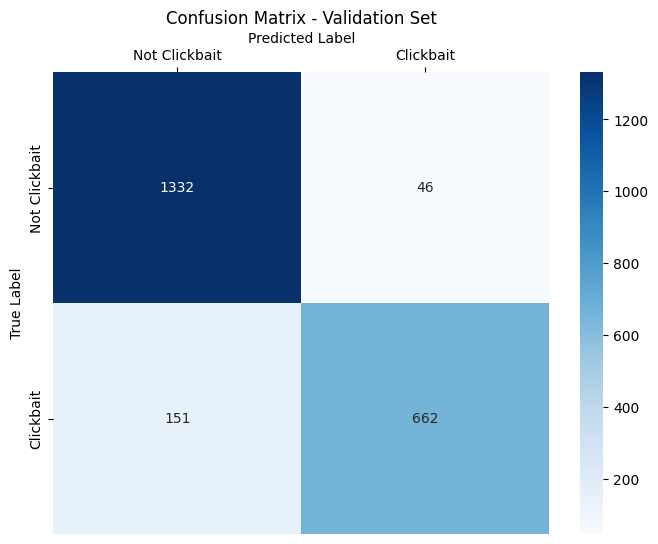

In [ ]:
# Look at individual examples in the valid split of the dataset

valid_split = dataset['validation']

print("\nEvaluating final model on validation set...")
valid_loss, valid_acc, valid_preds, valid_labels, valid_logits = evaluate(
    final_model,
    valid_split,
    batch_size=32,
    device=device,
    tokenizer=best_tokenizer
)
print(f"Validation Accuracy: {valid_acc:.4f}")
print(f"Validation Loss: {valid_loss:.4f}")
print(f"Validation F1 Score: {f1_score(valid_labels, valid_preds):.4f}")

# Create detailed classification report
print("\nDetailed Classification Report:")
report = classification_report(valid_labels, valid_preds, target_names=['Not Clickbait', 'Clickbait'], digits=4)
print(report)

cm = confusion_matrix(valid_labels, valid_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Clickbait', 'Clickbait'],
            yticklabels=['Not Clickbait', 'Clickbait'])
plt.title('Confusion Matrix - Validation Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()
plt.show()


In [ ]:
# Confidence scores
val_probs = torch.softmax(torch.tensor(valid_logits), dim=1).numpy()
val_confidence = np.max(val_probs, axis=1)


# Create analysis dataframe
analysis_df = pd.DataFrame({
    'text': [dataset['validation'][i]['text'] for i in range(len(val_labels))],
    'true_label': val_labels,
    'predicted_label': valid_preds,
    'confidence': val_confidence,
    'correct': np.array(valid_labels) == np.array(valid_preds)
})

analysis_df['error_type'] = 'Correct'
analysis_df.loc[(analysis_df['true_label'] == 0) & (analysis_df['predicted_label'] == 1), 'error_type'] = 'False Positive'
analysis_df.loc[(analysis_df['true_label'] == 1) & (analysis_df['predicted_label'] == 0), 'error_type'] = 'False Negative'


print(f"\nError Distribution:")
print(analysis_df['error_type'].value_counts())
print(f"Total validation examples: {len(analysis_df)}")


Error Distribution:
error_type
Correct           1994
False Negative     151
False Positive      46
Name: count, dtype: int64
Total validation examples: 2191


In [ ]:
# Display False Positives (True Label: 0, Predicted Label: 1)
print("\nFalse Positives (Non-Clickbait predicted as Clickbait)")
false_positive = analysis_df[analysis_df['error_type'] == 'False Positive'][['text', 'true_label', 'predicted_label', 'confidence']]
display(false_positive.head(30))

# Display False Negatives (True Label: 1, Predicted Label: 0)
print("\nFalse Negatives (Clickbait predicted as Non-Clickbait)")
false_negatives = analysis_df[analysis_df['error_type'] == 'False Negative'][['text', 'true_label', 'predicted_label', 'confidence']]
display(false_negatives.head(30))

print(f"\nTotal False Positives: {len(false_negatives)}")


False Positives (Non-Clickbait predicted as Clickbait)


,text,true_label,predicted_label,confidence
123,Here Are The 2017 Grammy Nominations,0,1,0.948387
191,5 Andra Day Songs You Should Know,0,1,0.996124
254,This Photo Of Harbhajan Singh's Toddler Bondin...,0,1,0.666066
301,7th Heaven television series comes to an end,0,1,0.556420
303,7 Dinners Under $10 You Should Make This Week,0,1,0.998622
333,The world's first craft beer hotel wants to so...,0,1,0.500809
339,The biggest meals on the world,0,1,0.733123
476,This $5 Million Desert Mansion Comes With Buil...,0,1,0.670188
478,"Tonight During Earth Hour, Here's How You Can ...",0,1,0.627787
493,Crucify But Everyone Sings It (Friday Night Fu...,0,1,0.762666



False Negatives (Clickbait predicted as Non-Clickbait)


,text,true_label,predicted_label,confidence
1,How Adulthood Happens,1,0,0.846981
18,Survey Points to Challenges NATO Faces Over Ru...,1,0,0.892144
57,If Marvel Superheroes Had Kids,1,0,0.541947
101,YouTube Meets Boob Tube as Europe’s Networks C...,1,0,0.854289
102,Whole Foods Wanted to Be More Than a Supermark...,1,0,0.870919
106,Gay in Putin's Moscow: why the city is pinker ...,1,0,0.612308
112,Family holidays Why our parents did holidays b...,1,0,0.566742
113,Night Owls Become Early Risers,1,0,0.718405
136,"What’s Making Britons Grumpy? Voting, Voting, ...",1,0,0.534535
161,"15-Year-Old Boy Discovers New Planet 1,000 Lig...",1,0,0.590032



Total False Positives: 151


In [ ]:
import re

In [ ]:
# Error Analysis Improvements

# Example of structural feaures
structural_features = {
    # Curiosity Gap Markers
    'deictic': bool,  # "This", "These", "That"
    'incomplete_info': bool,        # Ellipsis, "...", truncation

    # Exaggeration Patterns
    'exaggeration_count': int,       # "biggest", "best", "only", "never"
    'uniqueness_claims': bool,      # "You've never", "World's first"

    # Number Listicle Markers
    'number_list': bool,     # "7 Things...", "12 Ways..."
    'prescriptive': bool,  # "You Should", "You Need", "You Must"

}

def extract_clickbait_features(text):
    features = {}

    # Deictic references (strongest clickbait predictor)
    features['deictic'] = bool(re.search(r'\b(this|these|that)\b', text.lower()))

    # Incompleteness signals
    features['incomplete_info'] = '...' in text or len(text) > 50 and text[-1] not in '.!?'

    # Exagerrations
    exagerrations = ['biggest', 'best', 'worst', 'only', 'never', 'most', 'least']
    features['exaggeration'] = sum(s in text.lower() for s in exagerrations)

    # Number list
    features['number_list'] = bool(re.match(r'^\d+\s', text))

    # Prescriptive
    features['prescriptive'] = bool(re.search(r'\byou (should|must|need to|have to)\b', text.lower()))

    return features

In [ ]:
# let's use the confidence level as the prediction score to get the probability of the acttal prediction thus predict_prob = 1 - confidence score
# since the confidence score is the model's confidence (probability of correct pred) on the wrong prediction we subtract 1 which would be its confidence on the right prediction

clickbait = {'text':"This Is Not a Drill: You Can Now Intern for Ba...", 'score':0.470529} #  1 - 0.529471
non_clickbait = {'text':"12 things to know about Pluto", 'score':0.043658} # score = 1 - 0.956342


clickbait_features = extract_clickbait_features(clickbait['text'])
print("\nClickbait Features:")
print(clickbait_features)

non_clickbait_features = extract_clickbait_features(non_clickbait['text'])
print("\nNon Clickbait Features:")
print(non_clickbait_features)


Clickbait Features:
{'deictic': True, 'incomplete_info': True, 'exaggeration': 0, 'number_list': False, 'prescriptive': False}

Non Clickbait Features:
{'deictic': False, 'incomplete_info': False, 'exaggeration': 0, 'number_list': True, 'prescriptive': False}


In [ ]:
# using rule-based clickbair score

def rule_based_clickbait_score(text):
    score = 0.0

    # Strong clickbait indicators
    if re.match(r'^\d+\s', text):  # Starts with number
        score += 0.3

    if re.search(r'\b(this|these|that)\b', text.lower()) and '...' in text:
        score += 0.4  # Deictic + incomplete

    if re.search(r'\byou (should|must|can|need|won\'t believe)\b', text.lower()):
        score += 0.3

    # News indicators (reduce clickbait score)
    if re.search(r'\b(reveals|beyonce|earth|court|study shows)\b', text.lower()):
        score -= 0.2

    return score



In [ ]:
# Final prediction

clickbait_score = rule_based_clickbait_score(clickbait['text'])
non_clickbait_score = rule_based_clickbait_score(non_clickbait['text'])

print("clickbait rule score", clickbait_score)
print("Non clickbait rule score", non_clickbait_score)

clickbait_pred = clickbait['score']
non_clickbait_pred = non_clickbait['score']


final_clickbait_score = 0.7 * clickbait_pred + 0.3 * clickbait_score
final_non_clickbait_score = 0.7 * non_clickbait_pred + 0.3 * non_clickbait_score

print(f"Final Clickbait Score: {final_clickbait_score:.4f}")
print(f"Final Non-Clickbait Score: {final_non_clickbait_score:.4f}")

clickbait rule score 0.7
Non clickbait rule score 0.3
Final Clickbait Score: 0.5394
Final Non-Clickbait Score: 0.1206


## Submission Instructions

When you're ready to submit your assignment, please follow these steps:

1. Submit this completed ipynb **without clearing any output cells**, renamed as `hw3.ipynb`
   - Make sure your code can load the best model configuration
   - Include necessary functions for tokenization, prediction, etc.
   - Make sure it can run the test predictions on `test-DIST.json`

2. Download `test-results.txt` this notebook generated with your predictions on the provided test set. Perform a manual check to see if:
   - Each line should contain a single character: '1' for clickbait or '0' for non-clickbait
   - No other content should be in this file

3. Read and complete the hw3 report (report.pdf). It has the following sections:
   - Part 1: Model Selection
     - Compare BERT vs ModernBERT performance
     - Explain your choice of model and why it performed better
     - Discuss any observations about tokenization differences
   
   - Part 2: Hyperparameter Tuning
     - Table with all configurations tested and their results
     - Analysis of how different hyperparameters affected performance
     - Include and explain wandb plots
     - Justify your final model configuration

Submit the following files to Gradescope:
- `hw3.ipynb`: Your code implementation
- `test-results.txt`: Predictions on the test set
- `report.pdf`: Your detailed report

Make sure your name and Andrew ID are on the first page of your report.